# Book Ratings EDA and Prediction Model

### Import libraries

In [20]:
import pandas as pd
import numpy as np
import random
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.callbacks import Callback
import pymc3 as pm

from math import cos, sin, atan
from collections import OrderedDict
from IPython.display import clear_output
from tqdm import tqdm

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)

random_state = 249

### Required functions and classes

i) custom classes
* Neuron, Layer, Neural Network, and DrawNN classes referenced from https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network

In [21]:
class PlotLearning(Callback):
    '''
    Generates metric plots for visualizing train and test validation errors for neural network training.
    Incorporated as callback for each epoch training from model.
    '''
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            
    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

class CustomNormalizer():
    '''
    Object that normalizes numeric features columns based on different methods.
    Currently supports standard scaling (StandardScalar) from scikit-learn library.
    '''
    def __init__(self, norm_type):
        self._norm_fn = None
        if norm_type == 'z':
            # self._norm_fn = self._z_norm
            self._norm_fn = StandardScaler()

    @staticmethod
    def _z_score_params(df, col):
        mean = df[col].mean()
        std = df[col].std()
        return {'mean': mean, 'std': std}

    def _numeric_column_normalized(self, data):
        return self._norm_fn.transform(data)
        # return tf.feature_column.numeric_column(col, normalizer_fn=self._norm_fn)

    def _z_norm(self, col):
        return (col - self._mean) / self._std

    def fit(self, data):
        self._norm_fn.fit(data)
    
    def get_norm_params(self, df, features):
        assert isinstance(features, list), 'Feature names must be in a list.'
        normalization_parameters = {}
        for col in features:
            normalization_parameters[col] = self._z_score_params(df, col)
        return normalization_parameters

    def create_feature_cols(self, features=None, params=None, data=None, use_norm=False):
        normalized_feature_columns = []
        if use_norm:
            if bool(features) & bool(params):
                for col in features:
                    col_params = params[col]
                    self._mean, self._std = col_params['mean'], col_params['std'] 
                     # normalized_feature_columns.append(self._numeric_column_normalized(col))
        elif (isinstance(numeric_features_data, pd.DataFrame)) | (isinstance(numeric_features_data.to_numpy(), np.ndarray)):
            return self._numeric_column_normalized(data)
        # return normalized_feature_columns
        
class Neuron():
    '''
    Draws circle representing a basic neuron unit
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)

class Layer():
    '''
    Draws neuron layer (input, output and hidden) with connections between layers
    '''
    def __init__(self, network, number_of_neurons, neuron_label, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.neuron_label = neuron_label

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = plt.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        plt.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw(self.neuron_radius)
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            plt.text(x_text, self.y, 'Input Layer: {} neurons'.format(self.neuron_label), fontsize=12)
        elif layerType == -1:
            plt.text(x_text, self.y, 'Output Layer: {} neurons'.format(self.neuron_label), fontsize=12)
        else:
            plt.text(x_text, self.y, 'Hidden Layer {}: {} neurons'.format(str(layerType), self.neuron_label), fontsize=12)

class NeuralNetwork():
    '''
    Generic class that sets layer characteristics and draws the network
    '''
    def __init__(self, number_of_neurons_in_widest_layer, title, figsize):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0
        self.figsize = figsize
        self.title = title

    def add_layer(self, neuron_number, neuron_label):
        layer = Layer(self, neuron_number, neuron_label, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        plt.figure(figsize=self.figsize)
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw(i)
        plt.axis('scaled')
        plt.axis('off')
        plt.title(self.title, fontsize=15)
        plt.show()

class DrawNN():
    '''
    Object class that triggers neural network construction
    '''
    def __init__(self, neural_network, title, figsize=(40, 16), simplified=True):
        if simplified:
            neuron_for_graph = [1] * len(neural_network)
        else:
            neuron_for_graph = neural_network
        self.title = title
        self.figsize = figsize
        self.widest_layer = max(neuron_for_graph)
        self.neural_network = list(zip(neuron_for_graph, neural_network))

    def draw(self):
        network = NeuralNetwork(self.widest_layer, self.title, self.figsize)
        for n, l in self.neural_network:
            network.add_layer(n, l)
        network.draw()

ii) custom functions

In [22]:
def flag_common_words(col_name):
    '''
    Checks and flags if similar words are found in the subsequent row of a given column.
    '''
    flag = books_data2.shape[0] * [False]
    def check_val(idx, val, flag=flag, col=col_name):
        try:
            # print(books_data2.loc[idx + 1, col], val, val in books_data2.loc[idx + 1, col])
            return val in books_data2.loc[idx + 1, col]
        except:
            return False

    for idx, row in books_data2.iterrows():
        books_data2.loc[idx, 'is_present'] = check_val(idx, row[col_name])
        
def get_pure_list(df, root):
    '''
    Create non-duplicated pure list of values of given featuer
    '''
    return df.columns.str.extract(f'({root}.*)').dropna().drop_duplicates()[0].str.split('_', expand=True).replace({'': np.nan}).dropna().iloc[:, -1].tolist()

def get_neuron_count(model):
    model_config = model.get_config()
    layers = model_config['layers']
    neuron_list = []
    for layer in layers:
        name = layer['class_name']
        layer_config = layer['config']
        if 'Input' in name:
            _, neurons = layer_config['batch_input_shape']
        elif 'Dense' in name:
            neurons = layer_config['units']
        neuron_list.append(neurons)
    return neuron_list

def print_sample(item, i=1):
    title = f'Sample data item: {i}'
    print(title, '\n{}'.format(len(title) * '-'))
    for k, v in item.items():
        print(f'{k.upper()}: ', str(v))
        
def generate_sample(data, choice_list, gen_type='numeric'):
    tmp_data = None
    if gen_type == 'numeric':
        tmp_data = {i: j for i, j in zip(num_list, [random.choice(data[j]) for j in choice_list])}
        num_cols = pd.Series(tmp_data)[:6].index.to_numpy()
        sample = normalizer.create_feature_cols(data=pd.Series(tmp_data)[:6].to_numpy().reshape(1, -1), 
                                                         use_norm=False)
        sample = dict(zip(num_cols, sample[0]))
        return sample, tmp_data
    elif gen_type == 'publisher':
        publisher_choice = data.columns[data.columns.str.contains(random.choice(choice_list))]
        f_pub = lambda pub: 1 if pub == publisher_choice[0] else 0

        sel_pub = data.columns.str.contains('publisher_')
        sample = data.columns[sel_pub].to_frame().reset_index(drop=True).rename({0: 'publisher'}, axis=1)
        sample['indicator'] = sample['publisher'].apply(f_pub)
        return sample, publisher_choice
    elif gen_type == 'language':
        sel_lang = data.columns.str.contains('language_code_')
        sel_lang2 = data.columns[sel_lang].str.contains(random.choice(choice_list))
        lang_choice = data.columns[sel_lang][sel_lang2]
        f_lang = lambda lang: 1 if lang == lang_choice[0] else 0

        sel_lang = data.columns.str.contains('language_code_')
        sample = data.columns[sel_lang].to_frame().reset_index(drop=True).rename({0: 'language'}, axis=1)
        sample['indicator'] = sample['language'].apply(f_lang)
        return sample

### Import required data and mapping schemes

In [23]:
with open('replace.json') as f:
    replace_words = json.load(f)
    
file_name = 'books.xlsx'
file_folder = os.getcwd()
file_path = os.path.join(file_folder, file_name)

books_data = pd.read_excel(file_path)
books_data.columns = books_data.columns.str.replace('\s+', '')

### Data processing

1) Convert date columns to date data type
2) Remove extra spaces
3) Create new 'main_author' column consisting of only the primary author of book
4) Remove non-alphanumeric words and extra spaces
5) Simplifies publisher and language code to common form
6) Counts and records number of authors of given book 
7) Aggregate numerical features
8) Ranks publishers based on quantity of books published by them
9) Merge summarized numerical features (7) with publisher rank (9)
10) Create one-hot encodings of publishers and language code

In [24]:
# 1)
tmp_df = books_data[books_data['publication_date'].str.contains('/', regex=True, na=False)]
tmp_df_alt = books_data[~books_data['publication_date'].str.contains('/', regex=True, na=False)]
tmp_df['publication_date'] = pd.to_datetime(tmp_df['publication_date'].str.replace('31', '30'))
tmp_df_alt['publication_date'] = pd.to_datetime(tmp_df_alt['publication_date'])

# 2) & 3)
books_data2 = tmp_df.append(tmp_df_alt).drop_duplicates(keep='last').sort_values('bookID').reset_index(drop=True)
books_data2['title'] = books_data2['title'].str.replace('\s+', ' ').str.strip()
books_data2['publisher'] = books_data2['publisher'].str.replace('\s+', ' ')
books_data2['main_author'] = books_data2['authors'].str.split('/', expand=True)[0]

# 4)
for col in books_data2.columns:
    if str(books_data2[col].dtype) == 'object':
        books_data2[col] = books_data2[col].str.replace('[^A-Za-z0-9\-\.\/ ]+', '')
        books_data2[col] = books_data2[col].str.replace('\s+', ' ')

# 5)
for col in ['publisher', 'language_code']:
    books_data2[col].replace(replace_words[col], inplace=True)        

# 6) 
books_data2['num_authors'] = books_data2['authors'].apply(lambda x: len(x.split('/')))

# 7)
books_data3 = books_data2.copy()
books_data3.drop(['isbn', 'isbn13', 'publication_date', 'title'], axis=1, inplace=True)
books_data3 = books_data3.groupby(['main_author', 'num_authors', 'language_code', 'publisher']).agg(
    {'bookID': 'count', 
     'ratings_count': 'sum', 
     'text_reviews_count': 'sum', 
     'average_rating': 'mean', 
     'num_pages': 'mean'}
).reset_index().rename({'bookID': 'num_books'}, axis=1)
books_data3['publisher'] = books_data3['publisher'].str.replace('^\s{1}', '')

# 8)
publisher_rank = books_data3.groupby('publisher')['num_books'] \
                            .count() \
                            .reset_index() \
                            .sort_values('num_books', ascending=False) \
                            .rename({'num_books': 'num_publishers'}, axis=1)
excl_blank_publisher = publisher_rank[publisher_rank['publisher'] != '']
publisher_rank = excl_blank_publisher.append(publisher_rank[publisher_rank['publisher'] == '']).reset_index(drop=True)
publisher_rank['rank_publishers'] = np.arange(1, publisher_rank.shape[0] + 1)

# 9)
books_data3 = books_data3.merge(publisher_rank[['publisher', 'rank_publishers']], how='left', on='publisher')

# 10)
books_data4 = pd.concat([
    books_data3.drop(['main_author', 'language_code'], axis=1), 
    pd.get_dummies(books_data3[['publisher', 'language_code']], sparse=True)
], axis=1)

### Ratings summary

In [25]:
publisher_ratings_avg_count = books_data2.groupby('publisher')[['average_rating', 'ratings_count']].agg('mean', 'sum')

print('Basic summary of publisher ratings', '\n{}'.format('-' * len('Basic summary of publisher ratings')))
publisher_ratings_avg_count

Basic summary of publisher ratings 
----------------------------------


,average_rating,ratings_count
publisher,,
,4.300536,102.607143
,4.306667,55.666667
Kadokawa Shoten,3.815000,2.000000
Shogakukan,4.060000,0.000000
1st Book Library,3.580000,54.000000
...,...,...
dtv,4.170000,16.000000
iBooks,3.770000,552.888889
iUniverse,4.280000,394.333333


In [26]:
main_auth_ratings_avg_count = books_data2.groupby('main_author')[['average_rating', 'ratings_count']].agg('mean', 'sum').sort_values('average_rating', ascending=False)

print('Basic summary of main author ratings', '\n{}'.format('-' * len('Basic summary of main author ratings')))
main_auth_ratings_avg_count

Basic summary of main author ratings 
------------------------------------


,average_rating,ratings_count
main_author,,
Julie Sylvester,5.0,1.0
William C. Dowling,5.0,1.0
Elena N. Mahlow,5.0,4.0
Chris Green,5.0,1.0
Todd Davis,5.0,2.0
...,...,...
John Weld,0.0,0.0
Dan Hitt,0.0,0.0
Rick Osborne,0.0,0.0


### Visualizations

#### 1) Data density between different numerical columns

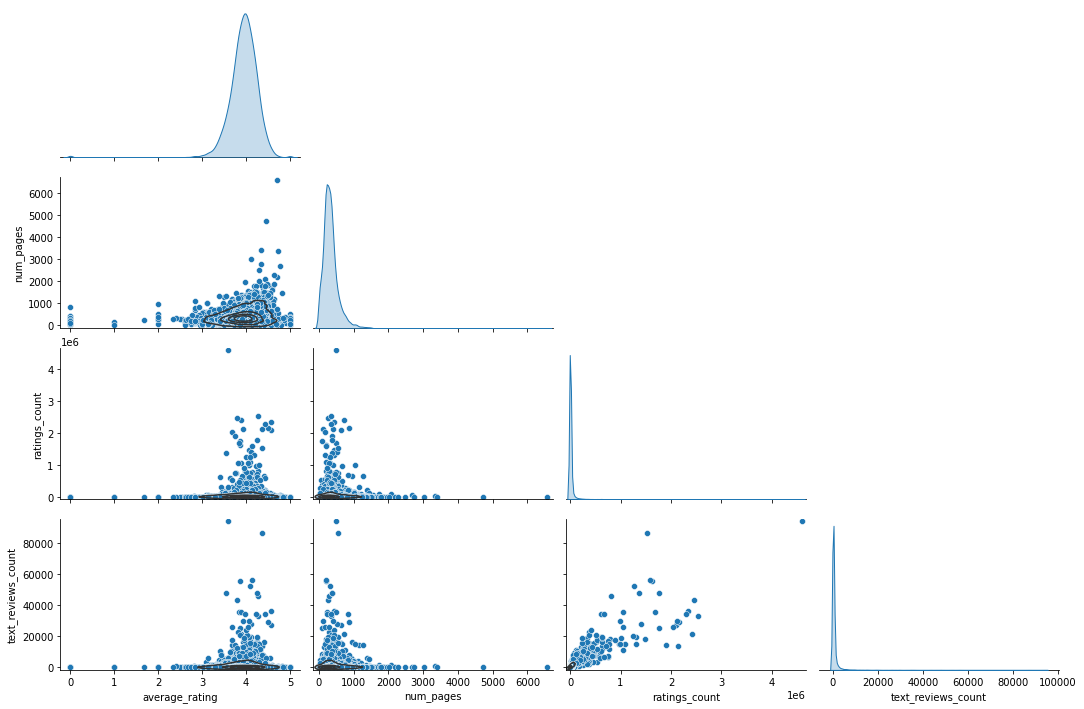

In [27]:
numericals_data = books_data2[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']]

g = sns.pairplot(numericals_data, diag_kind='kde', corner=True)
g.map_lower(sns.kdeplot, levels=5, color='0.2')
g.fig.set_size_inches(16, 10)

#### 2) Quantities of various features

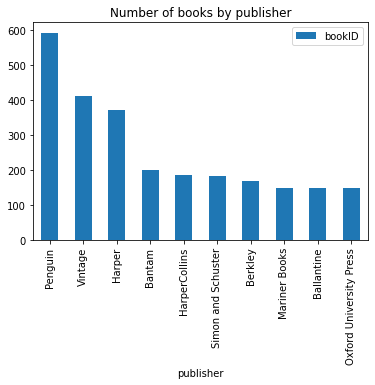

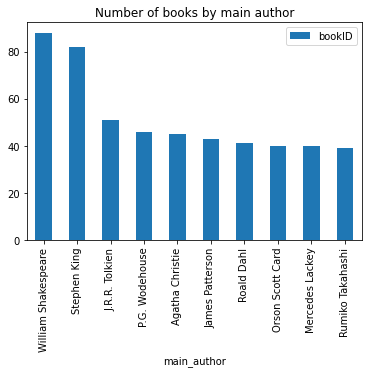

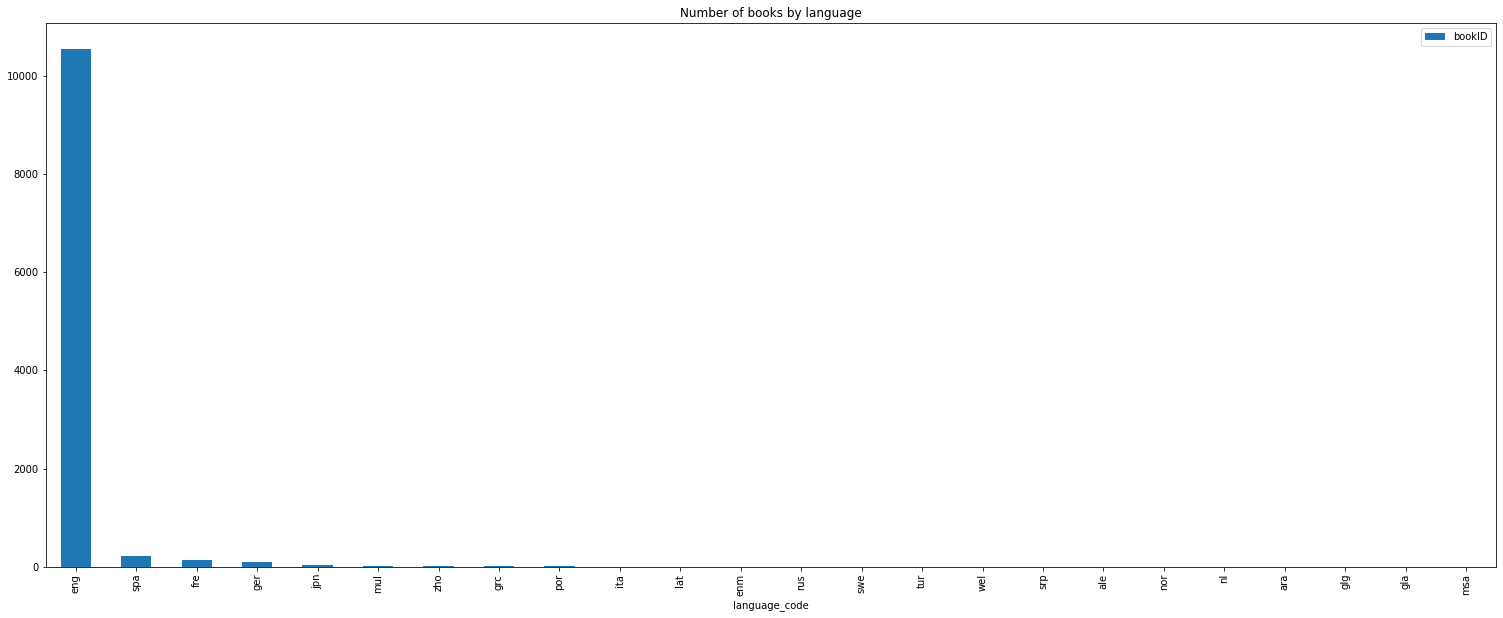

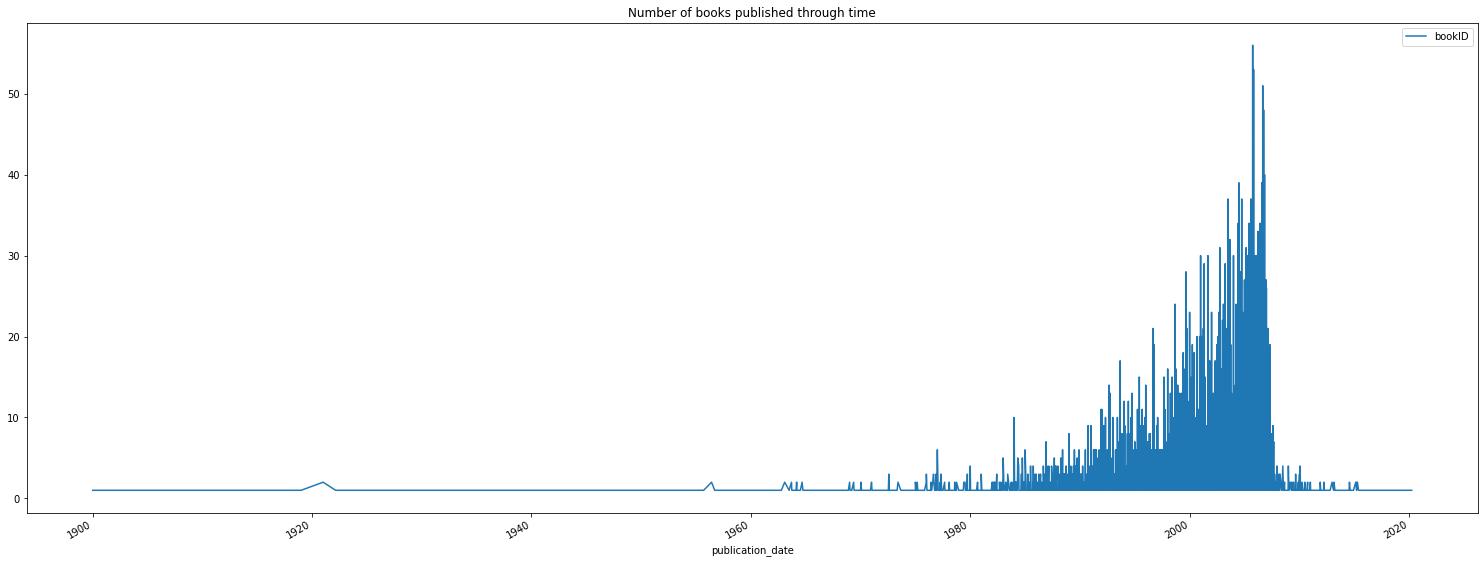

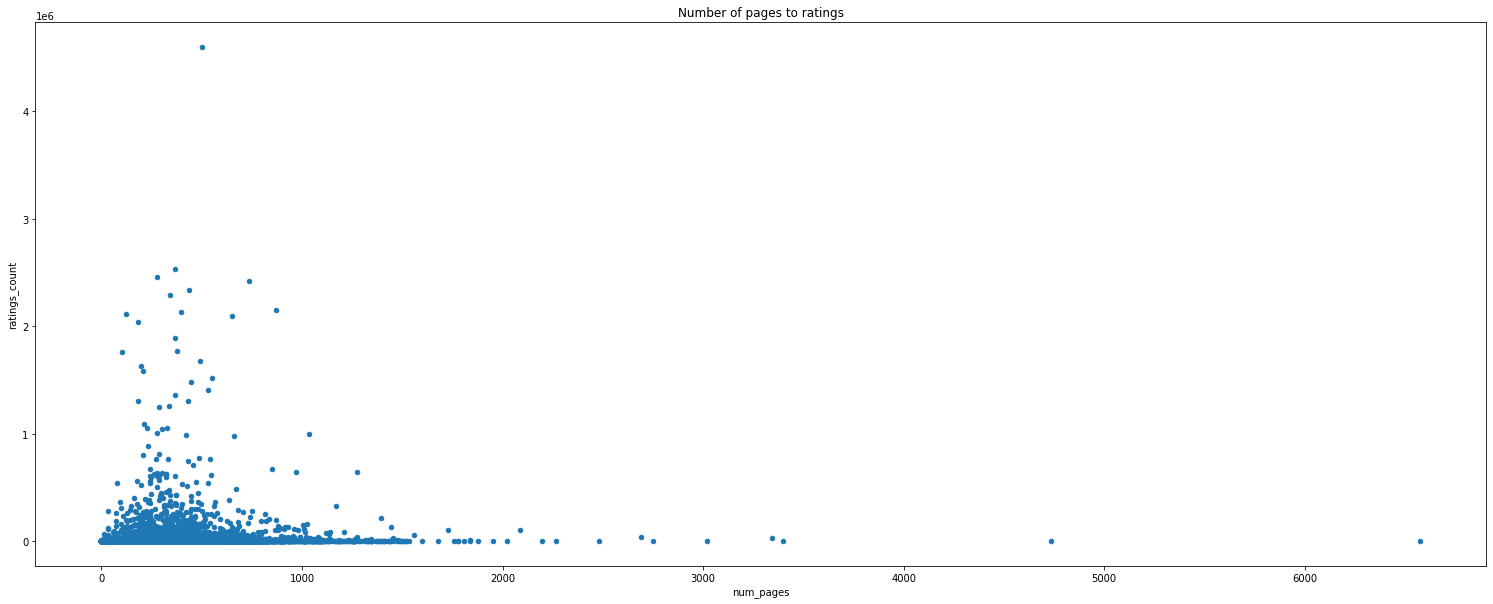

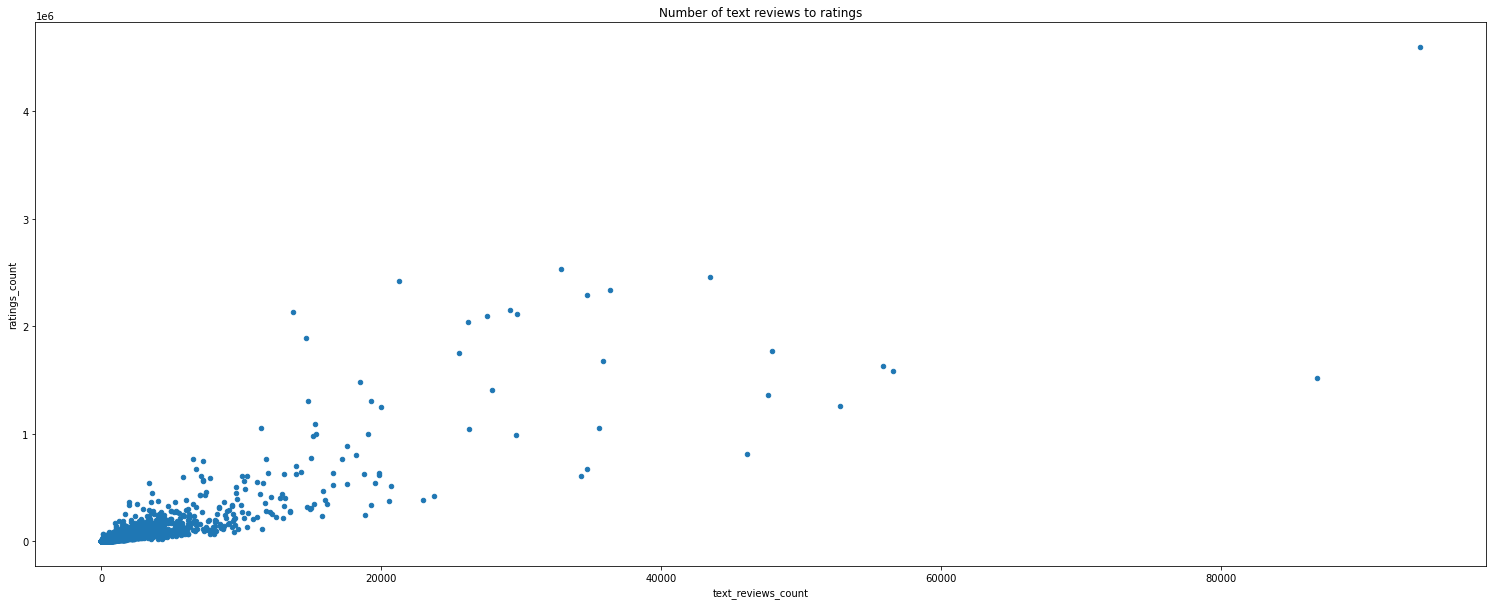

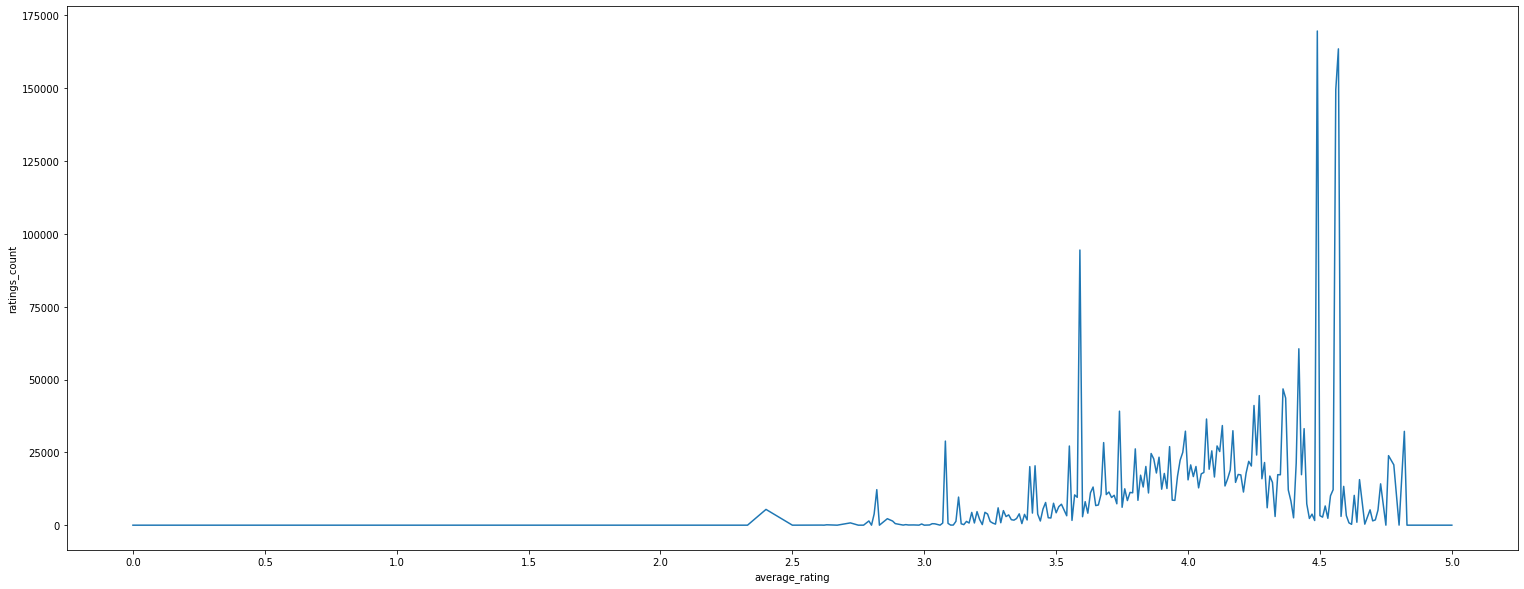

In [28]:
n = 10
num_ticks = 11
bar_top_n_publisher = books_data2.groupby('publisher')['bookID'].count().reset_index().sort_values('bookID', ascending=False)[:n]
bar_top_n_main_auth = books_data2.groupby('main_author')['bookID'].count().sort_values(ascending=False).reset_index()[:n]
bar_language = books_data2.groupby('language_code')['bookID'].count().reset_index().sort_values('bookID', ascending=False)
line_books = books_data2.groupby('publication_date')['bookID'].count().to_frame()

bar_top_n_publisher.plot(kind='bar', x='publisher', y='bookID', title='Number of books by publisher')
bar_top_n_main_auth.plot(kind='bar', x='main_author', y='bookID', title='Number of books by main author')
bar_language.plot(kind='bar', x='language_code', y='bookID', figsize=(26,10), title='Number of books by language')
line_books.plot(kind='line', y='bookID', title='Number of books published through time', figsize=(26,10))
books_data2.plot(kind='scatter', x='num_pages', y='ratings_count', figsize=(26,10), title='Number of pages to ratings')
books_data2.plot(kind='scatter', x='text_reviews_count', y='ratings_count', figsize=(26,10), title='Number of text reviews to ratings')

fig, ax = plt.subplots(figsize=(26,10))

xticks = np.linspace(0, np.ceil(max(books_data2['average_rating'])), num_ticks, dtype=np.float)
ax = sns.lineplot(x='average_rating', y='ratings_count', data=books_data2, ci=None)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks);

### Model

#### Dense neural network properties
- input layer + 5 hidden layers + output layer
- activation function:  ReLU
- optimizer:  Adam
- loss metric: MSE

#### Feature engineering
- Standard scale all numeric features based on mean and variance of entire dataset
- One-hot columns remain unaltered

In [29]:
model_data = books_data4.copy()
model_data.drop('publisher', axis=1, inplace=True)
features_data = model_data.drop('average_rating', axis=1)
label_data = model_data.pop('average_rating')

sel_non_num_cols = features_data.columns.str.contains('^publisher|^language_code', regex=True)
numeric_features_cols = features_data.columns[~sel_non_num_cols].tolist()
numeric_features_data = features_data[numeric_features_cols]

normalizer = CustomNormalizer('z')
# normalization_parameters = normalizer.get_norm_params(features_data, numeric_features_cols)
normalizer.fit(numeric_features_data)
feature_columns = normalizer.create_feature_cols(data=numeric_features_data, use_norm=False)

features_data2 = pd.concat([pd.DataFrame(feature_columns, columns=numeric_features_cols), features_data[features_data.columns[sel_non_num_cols]]], axis=1)

#### Create train and test data
- 20% test, 80% train
- From 80% train: 20% fit data, 80% validation data

In [30]:
features_data2 = features_data2.astype('float32')
label_data = label_data.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(features_data2, label_data, test_size=0.20, random_state=42)
X_train_fit, X_train_val, y_train_fit, y_train_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

#### Setting model architecture and configuration

In [31]:
%%time

callbacks_list = [PlotLearning()]

model = Sequential([
    Dense(features_data2.shape[1] + 300, activation='relu', input_dim=features_data2.shape[1]),
    Dense(features_data2.shape[1] + 500, activation='relu'),
    Dense(features_data2.shape[1] + 100, activation='relu'),
    Dense(np.floor(features_data2.shape[1] / 1.5).astype(int), activation='relu'),
    Dense(np.floor(features_data2.shape[1] / 5).astype(int), activation='relu'),
    Dense(1)
], name='primary')

model.compile(
    loss='mean_squared_error', 
    metrics=['mean_squared_error'], 
    optimizer=SGD(1e-3)
)

model.summary()

Model: "primary"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1785)              2652510   
_________________________________________________________________
dense_7 (Dense)              (None, 1985)              3545210   
_________________________________________________________________
dense_8 (Dense)              (None, 1585)              3147810   
_________________________________________________________________
dense_9 (Dense)              (None, 990)               1570140   
_________________________________________________________________
dense_10 (Dense)             (None, 297)               294327    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 298       
Total params: 11,210,295
Trainable params: 11,210,295
Non-trainable params: 0
_______________________________________________

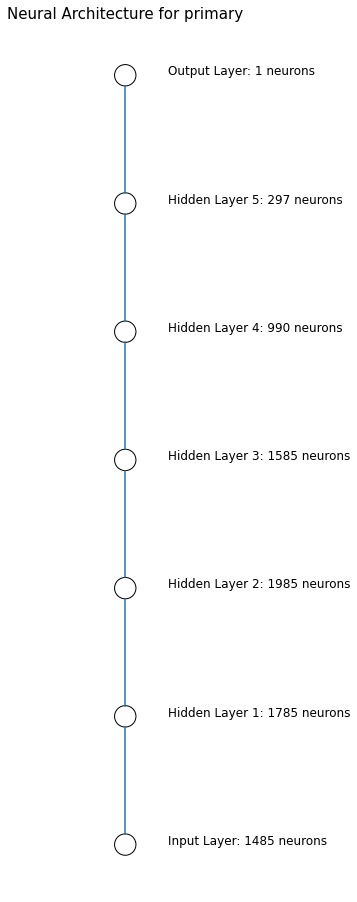

In [32]:
neuron_list = get_neuron_count(model)
network = DrawNN(neuron_list, f'Neural Architecture for {model.name}')
network.draw()

#### Train model

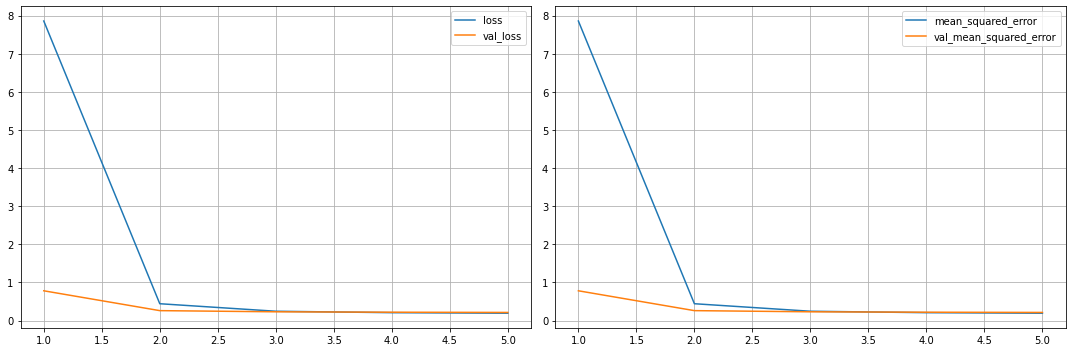

In [33]:
print("Fit model on training data")
history = model.fit(
    X_train_fit.to_numpy(),
    y_train_fit.to_numpy(),
    batch_size=64,
    epochs=5,
    validation_data=(X_train_val.to_numpy(), y_train_val.to_numpy()), 
    verbose=2,
    callbacks=callbacks_list
)

#### Calculate MSE of test data

In [34]:
test_mse = tf.keras.metrics.MeanSquaredError(name='test_mse')
test_mse.update_state(model.predict(X_test), y_test)

print('Mean squared error of test data: {}'.format(test_mse.result().numpy()))

Mean squared error of test data: 0.1778070628643036


In [35]:
lang_code_list = get_pure_list(features_data2, 'language_code_')
publisher_list = get_pure_list(features_data2, 'publisher_')

sel_lang_pub = features_data2.columns.str.contains('|'.join(lang_code_list)) | features_data2.columns.str.contains('|'.join(publisher_list))
num_list = features_data2.columns[~sel_lang_pub].drop('publisher_').tolist()

#### Generate predictive rating from sample

In [36]:
sample_data = OrderedDict()
sample_data_2, print_data = generate_sample(features_data, num_list)

publisher_sample, publisher_choice = generate_sample(features_data2, publisher_list, 'publisher')
sample_data_2 |= dict(zip(publisher_sample['publisher'], publisher_sample['indicator']))

lang_sample = generate_sample(features_data2, lang_code_list, 'language')
print_data |= {'publisher': publisher_choice.to_numpy()[0].split('_')[1]}
sample_data_2 |= dict(zip(lang_sample['language'], lang_sample['indicator']))

In [37]:
print_sample(print_data)

Sample data item: 1 
-------------------
NUM_AUTHORS:  2
NUM_BOOKS:  1
RATINGS_COUNT:  1598
TEXT_REVIEWS_COUNT:  3
NUM_PAGES:  199.0
RANK_PUBLISHERS:  598
PUBLISHER:  Black Sparrow Press


In [38]:
print('Result', '\n{}'.format('-' * len('Result')))
prediction = model.predict(pd.Series(sample_data_2).to_numpy().reshape(1,-1))[0][0]
print('{} / {}'.format(str(round(prediction, 2)), '5'))

Result 
------
3.3 / 5
